
<b>INSTITUTO FEDERAL DE GOIÁS<br/>
PÓS-GRADUAÇÃO EM INTELIGÊNCIA ARTIFICIAL APLICADA<br/></b>
Disciplina: Processamento de Linguagem Natural  <br/>
Professor: Daniel Xavier de Sousa <br/>
Alunos: Wagner Silva, Cleibson, Marcos Rodrigues


---

In [14]:
import pandas as pd
import numpy as np
import torch

from tqdm import tqdm

from transformers import AutoTokenizer, AutoModel

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

In [92]:
#Dropout: 0, 10%
DROPOUT = 0

#Learning rate: 2.5e-5 e 5e-5
LEARNING_RATE = 2.5e-5

In [4]:
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base", use_fast=True)
model = AutoModel.from_pretrained("xlm-roberta-base")

In [5]:
df = pd.read_csv('../datasets/buscape_preprocessed.csv')

In [6]:
df.head(3)

,review_text,rating
0,estou muito satisfeito o visor e melhor do que...,1
1,muito boa o que gostei preco o que nao gostei ...,1
2,rapida otima qualidade de impressao e facil de...,1


In [18]:
df.shape

(133632, 2)

In [19]:
reviews_part_01, reviews_part_02, labels_part_01, labels_part_02 = train_test_split(df['review_text'], df['rating'], test_size=0.5, random_state=42)

In [20]:
print(reviews_part_01.shape)
print(labels_part_01.shape)
print(reviews_part_02.shape)
print(labels_part_02.shape)

(66816,)
(66816,)
(66816,)
(66816,)


In [22]:
labels_part_01.value_counts()

rating
1    33477
0    33339
Name: count, dtype: int64

In [23]:
#reviews = ["This movie was great!", "I didn't like this movie.", "Ate que gostei", "Nao achei tao legal"]
#labels = [1, 0, 1, 0]
reviews = reviews_part_01
labels = labels_part_01

#### Tokenização e geração dos embeddings
- Este processo pode demorar alguns minnutos para ser concluído

In [24]:
embeddings = []
for review in tqdm((reviews),desc='Processing'):
    inputs = tokenizer(str(review), return_tensors="pt", padding=True, truncation=True, verbose=1)
    with torch.no_grad():
        output = model(**inputs)
    embeddings.append(output.last_hidden_state.mean(dim=1).numpy())

Processing: 100%|██████████| 66816/66816 [3:00:26<00:00,  6.17it/s]  


In [25]:
embeddings_array = np.vstack(embeddings)

In [26]:
print(f'{embeddings_array.shape[0]} embeddings de {embeddings_array.shape[1]} dimensões')

66816 embeddings de 768 dimensões


#### Feature based 2

In [28]:
additional_features_1 = np.array([[len(str(review).split())] for review in reviews])
additional_features_2 = np.array([[len(str(review_part_2).split())] for review_part_2 in reviews_part_02])

In [29]:
print(embeddings_array.shape)
print(additional_features_1.shape)
print(additional_features_2.shape)

(66816, 768)
(66816, 1)
(66816, 1)


#### Combinando embeddings_array e additional_features

In [30]:
#combined_features = np.hstack((embeddings_array, additional_features))
combined_features = np.hstack((embeddings_array, additional_features_1, additional_features_2))

#### Dividindo dataset treino e teste

In [31]:
X_train, X_test, y_train, y_test = train_test_split(combined_features, labels, test_size=0.2, random_state=42)

In [32]:
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)

2023-08-20 21:57:05.371795: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 164632160 exceeds 10% of free system memory.


In [33]:
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.float32)

#### Arquitetura rede neural MLP

In [93]:
model = Sequential([
    Dense(24, activation='relu', input_dim=X_train_tensor.shape[1]),
    Dropout(DROPOUT),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 24)                18504     
                                                                 
 dropout_3 (Dropout)         (None, 24)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 25        
                                                                 
Total params: 18,529
Trainable params: 18,529
Non-trainable params: 0
_________________________________________________________________


In [94]:
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy', metrics=['accuracy'])

#### Cross-validation

In [95]:
num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
verbose = 0

#### Treinamento do modelo

In [96]:
fold = 0

fold_accuracies = []
fold_f1_scores = []

train_loss_history = []
train_accuracy_history = []
for train_indices, val_indices in tqdm((kf.split(combined_features)), desc='Processing'):
    fold+=1
    print(f'fold = {fold}')
    
    X_train_fold = combined_features[train_indices]
    y_train_fold = np.array(labels)[train_indices]
    
    X_val_fold = combined_features[val_indices]
    y_val_fold = np.array(labels)[val_indices]
    
    X_train_fold_tensor = tf.convert_to_tensor(X_train_fold, dtype=tf.float32)
    y_train_fold_tensor = tf.convert_to_tensor(y_train_fold, dtype=tf.float32)
    
    X_val_fold_tensor = tf.convert_to_tensor(X_val_fold, dtype=tf.float32)
    y_val_fold_tensor = tf.convert_to_tensor(y_val_fold, dtype=tf.float32)
    
    model_history = model.fit(
        X_train_fold_tensor, 
        y_train_fold_tensor, 
        epochs=5, 
        batch_size=32, 
        verbose=verbose,
        validation_data=(X_val_fold_tensor, y_val_fold_tensor),
        callbacks=[EarlyStopping('loss', patience=3)],
    )
    
    y_pred_val = model.predict(X_val_fold_tensor)
    y_pred_val_binary = np.round(y_pred_val)
    
    fold_accuracy = accuracy_score(y_val_fold, y_pred_val_binary)
    fold_accuracies.append(fold_accuracy)
    
    fold_f1_score = f1_score(y_val_fold, y_pred_val_binary)
    fold_f1_scores.append(fold_f1_score)
    
    train_loss_history.append(model_history.history['loss'])
    train_accuracy_history.append(model_history.history['accuracy'])
    
print('Treino finalizado!')

Processing: 0it [00:00, ?it/s]

fold = 1
209/209 [==============================] - 0s 799us/step


Processing: 1it [00:11, 11.69s/it]

fold = 2
209/209 [==============================] - 0s 745us/step


Processing: 2it [00:23, 11.48s/it]

fold = 3
209/209 [==============================] - 0s 741us/step


Processing: 3it [00:35, 11.86s/it]

fold = 4
209/209 [==============================] - 0s 857us/step


Processing: 4it [00:57, 15.76s/it]

fold = 5
209/209 [==============================] - 0s 834us/step


Processing: 5it [01:08, 14.18s/it]

fold = 6
209/209 [==============================] - 0s 730us/step


Processing: 6it [01:19, 13.23s/it]

fold = 7
209/209 [==============================] - 0s 969us/step


Processing: 7it [01:32, 12.94s/it]

fold = 8
209/209 [==============================] - 0s 789us/step


Processing: 8it [01:53, 15.53s/it]

fold = 9
209/209 [==============================] - 0s 745us/step


Processing: 9it [02:04, 14.30s/it]

fold = 10
209/209 [==============================] - 0s 809us/step


Processing: 10it [02:15, 13.55s/it]

Treino finalizado!


In [97]:
print("Media Accuracy:", np.mean(fold_accuracies))
print("Media f1 score:", np.mean(fold_f1_scores))

Media Accuracy: 0.8350405562491406
Media f1 score: 0.8388008174210666


In [98]:
def plot_graphs(metrics_array, metric_name):
    plt.figure(figsize=(10, 6))
    for fold_num, fold_loss in enumerate(metrics_array):
        plt.plot(fold_loss, label=f'Fold {fold_num+1}')
    plt.xlabel('Epoch')
    plt.ylabel(f'Training {metric_name}')
    plt.title(f'Training {metric_name} per Epoch for Each Fold')
    plt.legend()
    plt.savefig(f'./graphs/tlm_peq_fb2_mlp_{metric_name}_train_01.png')
    plt.show()

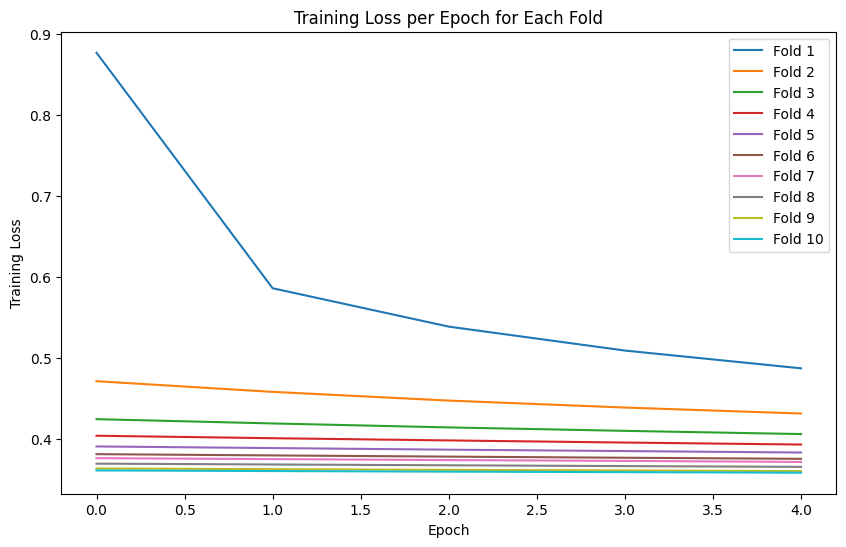

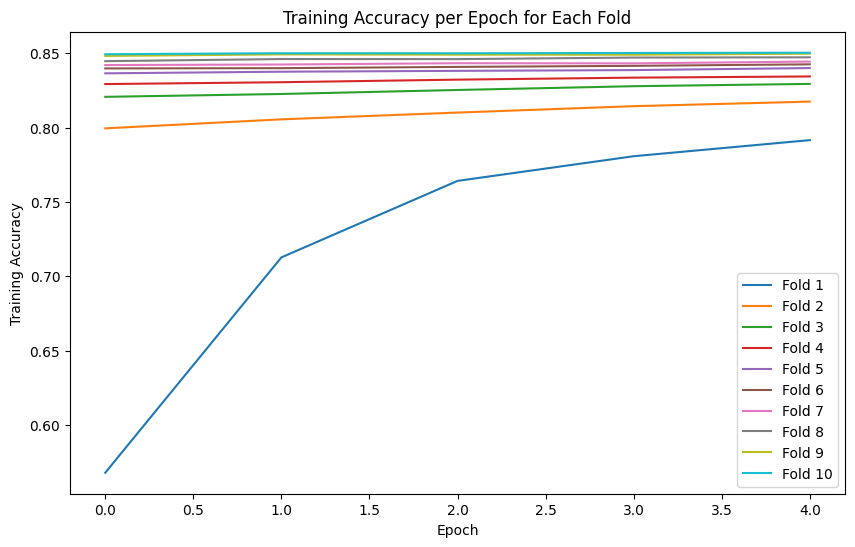

In [99]:
plot_graphs(train_loss_history, 'Loss')
plot_graphs(train_accuracy_history, 'Accuracy')

In [100]:
def plot_eval_metrics(model, metric):
    plt.plot(model.history[metric])
    plt.plot(model.history[f'val_{metric}'])
    plt.title(f'model {metric}')
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig(f'./graphs/tlm_peq_fb2_mlp_{metric}_train_01.png')
    plt.show()

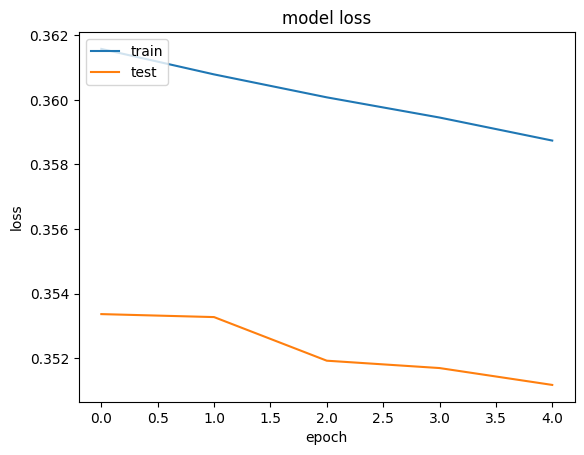

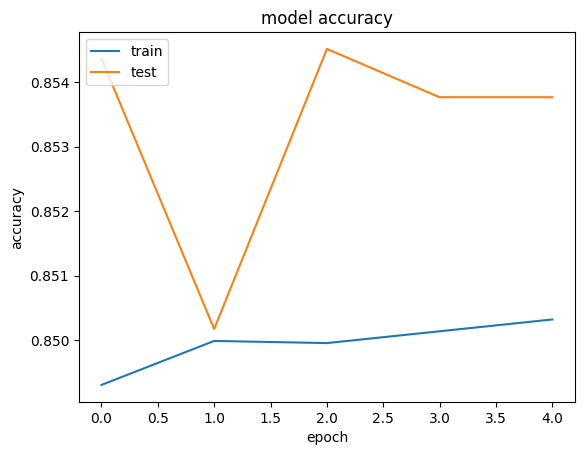

In [101]:
plot_eval_metrics(model_history, 'loss')
plot_eval_metrics(model_history, 'accuracy')